In [1]:
# uncomment the line below to obtain separat
%matplotlib inline
#%matplotlib qt


In [2]:
import bbci_lda
from matplotlib import pyplot as plt
import numpy as np
import os
import mne
import itertools
# LDA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold

## Define the analysis variables

In [3]:
data_dir=r"C:\BCI\dev\p300_analysis_from_openvibe"

# Visual
display_preprocessing_plots = False
display_all_erp_plots = False


# Preprocessing
apply_infinite_reference = True  # rereferencing
apply_ASR = True  # use Artifact Subspace Reconstruction (artifact removal)
apply_CSD = True  # use Current Source Density (spatial filter)

drop_bad_epochs = False
reject_channels_full_of_artifacts = True
reject_artifactual_epochs = reject_channels_full_of_artifacts and True # do not reject epochs if you dont reject channels or use CSD
artifact_threshold = 100e-6
ratio_tolerated_artifacts = 0.3  # if 30% of artifacts in 200ms windows, then the channel is rejected

# ERP analysis parameters (values in sec)
isi = .0625
flash = .125
pre_epoch = -.200
epoch_length = .800

# LDA
resample_LDA = 32 # Hz
nb_k_splits = 5



## Load the data files

In [4]:
os.path.exists(data_dir)
fnames = []
for file in os.listdir(data_dir):
    if file.endswith(".gdf"):
        fnames.append(os.path.join(data_dir, file))
        print(os.path.join(data_dir, file))
        
# load and preprocess data ####################################################
raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]
#raw = concatenate_raws(raws)
raw = raws[0]

C:\BCI\dev\p300_analysis_from_openvibe\loic_gammabox.gdf
C:\BCI\dev\p300_analysis_from_openvibe\loic_old_12ch-10seq.gdf
Extracting EDF parameters from C:\BCI\dev\p300_analysis_from_openvibe\loic_gammabox.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 85055  =      0.000 ...   166.123 secs...
Extracting EDF parameters from C:\BCI\dev\p300_analysis_from_openvibe\loic_old_12ch-10seq.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84383  =      0.000 ...   164.811 secs...


<ipython-input-4-5e181bcbe37e>:9: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]
<ipython-input-4-5e181bcbe37e>:9: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]


rename the electrodes

In [5]:
nb_chan = len(raw.info['ch_names'])
# define channel names
if nb_chan==12 or  nb_chan==10:
    cname = ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']
else:
    cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']
    
nb_def_ch = len(cname)


if nb_chan>8:
    cname.extend(["ch{}".format(i) for i in range(nb_def_ch+1,nb_chan+1)])
print(cname)
cname_map = dict(zip(raw.info['ch_names'], cname))
# define channel types
types = list(itertools.repeat('eeg', nb_def_ch))
if len(raw.info['ch_names'])>nb_def_ch:
    types.extend(list(itertools.repeat('misc', nb_def_ch)))
type_map = dict(zip(cname, types))

# rename and pick eeg
raw.rename_channels(cname_map, allow_duplicates=False)
raw.set_channel_types(type_map)
raw.pick_types(eeg=True, misc=False)

['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']


<RawGDF | loic_gammabox.gdf, 10 x 85056 (166.1 s), ~6.5 MB, data loaded>

Set the montage

In [6]:
montage = mne.channels.make_standard_montage('standard_1005')
raw = raw.set_montage(montage, match_case=False) 

Check whether there are bad channels 

In [7]:
# Using 50Hz power variance
psd, freqs = mne.time_frequency.psd_welch(raw,verbose=True)
power_50hz = psd[:,np.where(freqs ==60)]
print('50Hz variance: {}'.format(mne.preprocessing.bads._find_outliers(power_50hz.squeeze(), threshold=3, max_iter=5, tail=0)))


# using variance
ch_var  = [np.var(raw._data[i,:]) for i in list(range(raw._data.shape[0]))]
print('Variance: {}'.format(mne.preprocessing.bads._find_outliers(ch_var, threshold=3, max_iter=5, tail=0)))

Effective window size : 0.500 (s)
50Hz variance: []
Variance: []


rereferencing

In [8]:
if apply_infinite_reference:
    raw.del_proj()  # remove our average reference projector first
    sphere = mne.make_sphere_model('auto', 'auto', raw.info)
    src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
    forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
    raw_rest = raw.copy().set_eeg_reference('REST', forward=forward)
    
    if display_preprocessing_plots:
        for title, _raw in zip(['Original', 'REST (∞)'], [raw, raw_rest]):
            fig = _raw.plot(n_channels=len(raw), scalings=dict(eeg=5e-5))
            # make room for title
            fig.subplots_adjust(top=0.9)
            fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

Fitted sphere radius:         95.6 mm
Origin head coordinates:      0.4 4.5 48.5 mm
Origin device coordinates:    0.4 4.5 48.5 mm

Equiv. model fitting -> RV = 0.00489443 %
mu1 = 0.943729    lambda1 = 0.139922
mu2 = 0.662475    lambda2 = 0.696337
mu3 = 0.284019    lambda3 = -0.0258893
Set up EEG sphere model with scalp radius    95.6 mm

Sphere                : origin at (0.4 4.5 48.5) mm
              radius  : 86.1 mm
grid                  : 15.0 mm
mindist               : 5.0 mm
Exclude               : 30.0 mm

Setting up the sphere...
Surface CM = (   0.4    4.5   48.5) mm
Surface fits inside a sphere with radius   86.1 mm
Surface extent:
    x =  -85.7 ...   86.5 mm
    y =  -81.6 ...   90.5 mm
    z =  -37.6 ...  134.6 mm
Grid extent:
    x =  -90.0 ...   90.0 mm
    y =  -90.0 ...  105.0 mm
    z =  -45.0 ...  135.0 mm
2366 sources before omitting any.
762 sources after omitting infeasible sources not within 30.0 - 86.1 mm.
639 sources remaining after excluding the sources outsi

<ipython-input-8-e993b98fe1b9>:3: RuntimeWarning: Only 10 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom EEG reference.
    10 out of 10 channels remain after picking


## Bandpass the signal
Removes noise and drift from the EEG signal by applying a infinite impulse response (two-pass) filter between .5 and 40Hz

In [9]:
raw.filter(.5, 40, fir_window='hann', method='iir')
raw.notch_filter(50)  # removes 50Hz noise
if display_preprocessing_plots:
    raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 sec)



## Excluding of channels full of artifacts (muscular or disconnecting)

Not setting metadata
Not setting metadata
1660 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1660 events and 102 original time points ...
0 bad epochs dropped
(1660, 10)


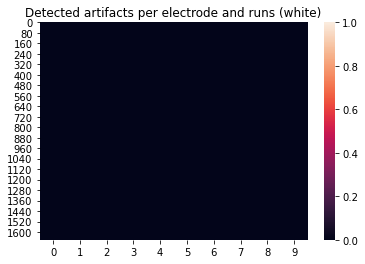

In [10]:
import seaborn as sns
#Apply a variance based channel rejection if artifacts are present >30% of the time
def detec_rej_channel(raw, duration=.2, overlap_duration=.1, threshold_eeg=artifact_threshold, reject_ratio=ratio_tolerated_artifacts):

    epochs_rej = mne.make_fixed_length_epochs(raw,duration=duration, overlap=overlap_duration, preload=True)
    epochs_rej._data.shape
    diff = np.max(epochs_rej._data, axis=2) - np.min(epochs_rej._data, axis=2)

    print(diff.shape)

    rej = (diff>=threshold_eeg).astype(np.float64)
    rel = sns.heatmap(rej)
    rel.set(title='Detected artifacts per electrode and runs (white)')

    # calculate ratio of rejected trials
    ratios = np.sum(rej,axis=0) / rej.shape[0]
    
    ret = np.argwhere(ratios >= reject_ratio).tolist()
    if len(ret)>0 and len(ret[0]):
        print('Found {} channels with at least {}% {}s epochs > {} amplitude)'.format(len(ret), 
                                                                                              reject_ratio*100, duration,
                                                                                      threshold_eeg))
        return ret[0]
    else:
        return None
    
    
if reject_channels_full_of_artifacts:
    rej_ch = detec_rej_channel(raw)
    if rej_ch is not None:
        new_bads = [raw.info['ch_names'][ch] for ch in rej_ch]
        raw.info['bads'].extend(new_bads)
        raw.pick_types(eeg=True)


## Artifact Subspace Reconstruction fitting and reconstruction

In [11]:
if apply_ASR:
    #!pip install meegkit pymanopt
    from meegkit.asr import ASR
    fs = int(raw.info["sfreq"])  # sampling frequency
    method='riemann'  # if error, use 'euclid' -> actually the case
    window_s=.5  # .5 sec window of analysis
    data_interval_s  = None # (begin, end) in sec of the training sample
    estimator='lwf'  #leave blank if using euclidian mode 

    # define the ASR model using riemannian method
    #asr_model = ASR(sfreq=fs, method=method, win_len=window_s, estimator=estimator)

    # if failing (after trying twice. SVD error occurs for no reason sometimes)
    asr_model = ASR(sfreq=fs, method="euclid", win_len=window_s)

    # The best would be to choose another recording during the same session to train the model without overfitting
    data = raw._data  # the numpy array with data is stored in the _data variable

    # Select a time interval for training data
    train_idx = None
    if data_interval_s is not None:
        train_idx = np.arange(data_interval_s[0] * fs, data_interval_s[1] * fs, dtype=int)
    # otherwise select the whole training set
    else:
        train_idx = np.arange(0, data.shape[1])

    train_data = data[:, train_idx]
    print('Training on samples of size {}'.format(train_data.shape))

    # fir the ASR model with data intervals
    _, sample_mask = asr_model.fit(train_data)
    print('Model trained')


Training on samples of size (10, 85056)
Model trained


### Clean the current dataset
Please check whether using this artifact filtering method increases signal to noise ratio rather than reducing it

In [12]:
if apply_ASR:
    clean =  asr_model.transform(raw._data)

    display_window_s = 30  # 

    if display_preprocessing_plots:  #
        data_p = raw._data[0:fs*display_window_s]  # reshape to (n_chans, n_times)
        clean_p = clean[0:fs*display_window_s]

        ###############################################################################
        # Plot the results
        # -----------------------------------------------------------------------------
        #
        # Data was trained on a 40s window from 5s to 45s onwards (gray filled area).
        # The algorithm then removes portions of this data with high amplitude
        # artifacts before running the calibration (hatched area = good).
        nb_ch_disp = len(raw.info['ch_names'])
        times = np.arange(data_p.shape[-1]) / fs
        f, ax = plt.subplots(nb_ch_disp, sharex=True, figsize=(32, 16))
        for i in range(nb_ch_disp):
            # ax[i].fill_between(train_idx / fs, 0, 1, color='grey', alpha=.3,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   label='calibration window')
            # ax[i].fill_between(train_idx / fs, 0, 1, where=sample_mask.flat,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   facecolor='none', hatch='...', edgecolor='k',
            #                   label='selected window')
            ax[i].plot(times, data_p[i], lw=.5, label='before ASR')
            ax[i].plot(times, clean_p[i], label='after ASR', lw=.5)
            # ax[i].plot(times, raw[i]-clean[i], label='Diff', lw=.5)
            # ax[i].set_ylim([-50, 50])
            ax[i].set_ylabel(f'ch{i}')
            ax[i].set_yticks([])
        ax[i].set_xlabel('Time (s)')
        ax[0].legend(fontsize='small', bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.subplots_adjust(hspace=0, right=0.75)
        plt.suptitle('Before/after ASR')
        plt.show()
    raw.data_ = clean

### Convert text annotations (i.e. unprocessed events) into events

**Small but major hack to realign events due to conversion**

In [13]:
print("Erroneous annotations: {}".format(raw.annotations.description))
print('Note here that the first annotation is 0 or 1, this is an error and thus we shift the annotations to retrieve the correct timings')
raw.annotations.description = np.roll(raw.annotations.description, -1)
print("Corrected annotations: {}".format(raw.annotations.description))

# in case you want to debug the issue, I left here a way to visualize them
# retrieving the list of annotations
import pprint
print(raw.annotations.to_data_frame())
df = raw.annotations.to_data_frame()
print('Displaying all annotations')
annot_codes = [np.int64(n) for n in np.unique(df['description'])]
df['description'] = df['description'].astype(int)

if False:
    # to see and debug the fill list of annotations
    import pandas as pd
    pd.set_option('display.max_rows', None)
    #a = df[df['description'] != 33286]
    #print(a)
    print(df)
    pd.set_option('display.max_rows', 32)

Erroneous annotations: ['1' '32773' '33035' ... '33286' '32779' '32780']
Note here that the first annotation is 0 or 1, this is an error and thus we shift the annotations to retrieve the correct timings
Corrected annotations: ['32773' '33035' '33286' ... '32779' '32780' '1']
                          onset  duration description
0    1970-01-01 00:00:11.876953  0.001953       32773
1    1970-01-01 00:00:11.876953  0.001953       33035
2    1970-01-01 00:00:11.876953  0.001953       33286
3    1970-01-01 00:00:11.876953  0.001953       32779
4    1970-01-01 00:00:11.939453  0.001953       32780
...                         ...       ...         ...
2805 1970-01-01 00:02:43.431641  0.001953       33030
2806 1970-01-01 00:02:43.431641  0.001953       33286
2807 1970-01-01 00:02:43.431641  0.001953       32779
2808 1970-01-01 00:02:43.494141  0.001953       32780
2809 1970-01-01 00:02:43.626953  0.001953           1

[2810 rows x 3 columns]
Displaying all annotations


### Make a list of the annotations to check whether all stimuli can be found

These annotations seem to relate to hex codes. OpenViBE definitions can be found on [OpenViBE's website](http://openvibe.inria.fr/stimulation-codes/). Let's parse the copypasted list

Make a dataframe of the stimuli in common between both

In [14]:
import pandas as pd

import re
tr_sim= ''
pat_extract= re.compile('^([^ ]+)[ ]+0x[0-9A-Fa-f]+[ \/]+([0-9]+)')
#OVTK_GDF_125_Watt                                     0x585       //  1413
k_stim = []
k_stim_int = []
v_stim = []

# read and convert annotations
with open(r'.\ov_stims.txt', 'r') as fd:
    for line in fd.readlines():
        m = pat_extract.match(line)
        v, k = m.groups()
        k_stim.append(k)
        k_stim_int.append(int(k))
        v_stim.append(v)

# format dict and list
stim_map = dict(zip(k_stim_int, v_stim))
stim_map_inv = dict(zip(v_stim, k_stim))

stim_tup = list(zip(k_stim_int, v_stim))

df = pd.DataFrame.from_dict(stim_tup)
df.columns = ['coden', 'desc']
df[[c in annot_codes for c in df.coden]]

,coden,desc
125,33025,OVTK_StimulationId_Label_01
126,33026,OVTK_StimulationId_Label_02
127,33027,OVTK_StimulationId_Label_03
128,33028,OVTK_StimulationId_Label_04
129,33029,OVTK_StimulationId_Label_05
130,33030,OVTK_StimulationId_Label_06
131,33031,OVTK_StimulationId_Label_07
132,33032,OVTK_StimulationId_Label_08
133,33033,OVTK_StimulationId_Label_09
134,33034,OVTK_StimulationId_Label_0A


From this table, we could locate and save the codes for **Target and Non-Target** and give them the following values: target=1 and non-target=0 

In [15]:
# target = 1, nontarget = 0
target_map = {'33286':0, '33285':1}

Then we can convert annotations into events

In [16]:
events, _ = mne.events_from_annotations(raw, event_id=target_map)
print("Found {} events".format(len(events[:])))

Used Annotations descriptions: ['33285', '33286']
Found 700 events


### Pick the channels

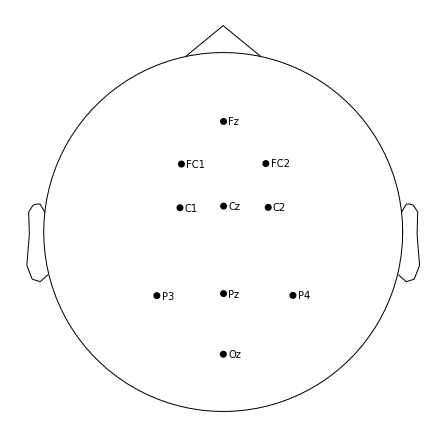

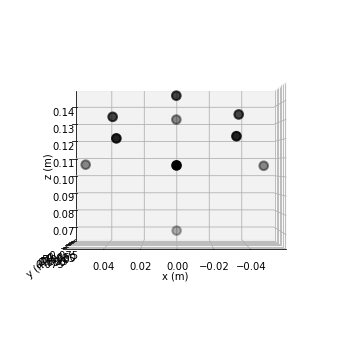

In [17]:
# pick all channels
picks = mne.pick_channels(raw.info["ch_names"], include=[])
picks
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

## Epoching from events

Check for duplicates

In [18]:
from collections import Counter
events[:, 0]
a = np.array(events[:, 0])
dups = [item for item, count in Counter(a).items() if count > 1]
if dups:
    print("WARNING: Duplicate found at sample(s) {}".format(dups))

In [50]:
event_ids = dict(NonTarget=0, Target=1) 
isi = isi
flash = flash
pre_epoch = pre_epoch
epoch_length = epoch_length


# epoching function
epochs = mne.Epochs(raw, events, baseline=(-.2, 0), event_id=event_ids, tmin=pre_epoch, tmax=epoch_length, event_repeated='drop', picks = ['eeg', 'csd'],
                    preload=True, decim=4)

# if there is any delay,
#epochs.shift_time(-isi, relative=True)
if display_preprocessing_plots:
    fig = epochs.plot()

Not setting metadata
Not setting metadata
700 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 700 events and 513 original time points ...
0 bad epochs dropped


### Making a cross correlation plot between the electrodes to see how channels relate

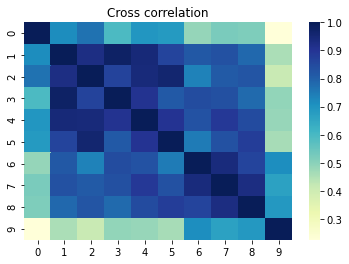

In [51]:
m = np.corrcoef(raw._data)
fig = plt.plot()
hm = sns.heatmap(m,linewidths=0,cmap="YlGnBu").set(title='Cross correlation')


### Epoch rejection
Please filter out channels before epochs. A problematic channel can discard the whole recording

In [52]:
if reject_artifactual_epochs:
    reject_criteria = dict(eeg=100e-6)  # 100 µV  #eog=200e-6)
    _ = epochs.drop_bad(reject=reject_criteria)
    if display_preprocessing_plots:
        epochs.plot_drop_log()

    Rejecting  epoch based on EEG : ['Fz']
1 bad epochs dropped


## Apply current source density

In [53]:
if apply_CSD:
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    epochs = epochs_csd
    if display_preprocessing_plots:
        epochs_csd.plot()


Fitted sphere radius:         95.6 mm
Origin head coordinates:      0.4 4.5 48.5 mm
Origin device coordinates:    0.4 4.5 48.5 mm


<ipython-input-53-1a0bbb77807d>:2: RuntimeWarning: Only 10 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  epochs_csd = mne.preprocessing.compute_current_source_density(epochs)


### Average the epochs of each class

In [54]:
l_nt = epochs['NonTarget'].average()
l_target = epochs['Target'].average()

target and non target signal plots

In [55]:
if display_all_erp_plots:
    fig, ax = plt.subplots(2, 1)
    fig1 = l_target.plot(spatial_colors=True, axes=ax[0], show=False)
    fig2 = l_nt.plot(spatial_colors=True, axes=ax[1], show=False)
    # Add title
    fig.suptitle("Target(top) - Non-Target(bottom)")
    # Fix font spacing
    plt.subplots_adjust(hspace=0.5)
    plt.show()

target and non target signal topomaps

In [56]:
if display_all_erp_plots:
    spec_kw = dict(width_ratios=[1,1,1,.15], wspace=0.5,
                   hspace=0.5,height_ratios=[1,1])
                             #hspace=0.5, height_ratios=[1, 2])

    fig, ax = plt.subplots(2, 4, gridspec_kw=spec_kw)
    l_target.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[0,:], show=False)
    l_nt.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[1,:], show=False)
    fig.suptitle("Target(top) - Non-Target(bottom)")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

joint plot (of the two former graphs). Plase not that Y scales differ between plots 

No projector specified for this dataset. Please consider the method self.add_proj.


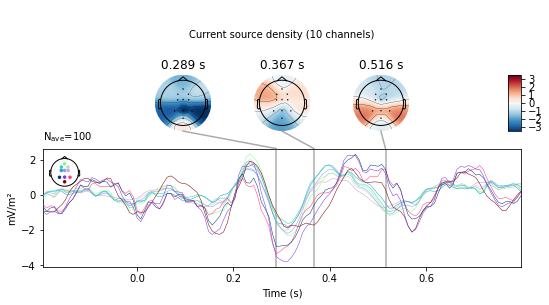

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 432x288 with 0 Axes>

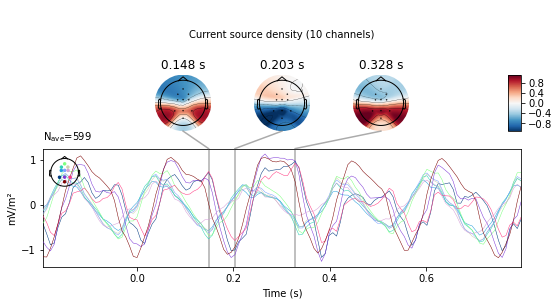

<Figure size 432x288 with 0 Axes>

In [57]:
l_target.plot_joint()
plt.gcf().canvas.set_window_title('Target joint plot')
l_nt.plot_joint()
plt.gcf().canvas.set_window_title('Non-Target joint plot')

Average plots

In [58]:
if display_all_erp_plots:
    evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
                   Target=list(epochs['Target'].iter_evoked()))
    #picks = [f'eeg{n}' for n in range(10, 15)]
    mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

### Target vs NonTarget Erps per channel

plotting channel 1
plotting channel 2
plotting channel 3
plotting channel 4
plotting channel 5
plotting channel 6
plotting channel 7
plotting channel 8
plotting channel 9
plotting channel 10
plotting averaged channels
combining channels using "mean"
combining channels using "mean"


<ipython-input-59-30ddcda7e259>:20: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean',


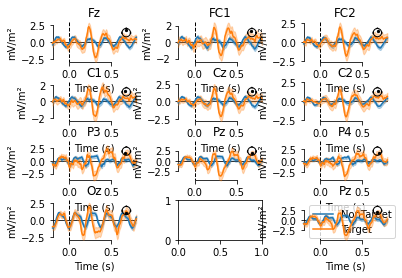

Please note that this plot is optimized for higher resolution and has the legend overlapping the average


In [59]:
nb_chans = epochs['Target']._data.shape[1]
splt_height = int(np.ceil(np.sqrt(1.0*nb_chans+1)))  # adding an extra plot with all channels combined at the end
splt_width = splt_height if splt_height * splt_height == nb_chans+1 else splt_height-1
fig, ax = plt.subplots(splt_height,splt_width)

evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
#picks = [f'eeg{n}' for n in range(10, 15)]

shape_epochs = epochs['Target']._data.shape
for ch_idx in range(nb_chans):
    print('plotting channel {}'.format(ch_idx+1))
    mne.viz.plot_compare_evokeds(evokeds,picks=[epochs.info['ch_names'][ch_idx]],
                                 legend=False,
                                 axes=ax[ch_idx//splt_width, ch_idx%splt_width], show=False)
    #plt.show(block=False)
    plt.subplots_adjust(hspace=0.5, wspace=.5)
    #plt.pause(.1)
print('plotting averaged channels')
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean',
                             legend=True,
                             axes=ax[-1,-1], show=False)

plt.subplots_adjust(hspace=0.5, wspace=.5)
plt.show()
print("Please note that this plot is optimized for higher resolution and has the legend overlapping the average")

### Display epoch at Cz and Pz

### Display single epochs

Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


<ipython-input-44-76e37879f247>:2: RuntimeWarning: Only one channel in group "csd"; cannot combine by method "mean".
  epochs['Target'].plot_image(combine='mean')
<ipython-input-44-76e37879f247>:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs['Target'].plot_image(combine='mean')


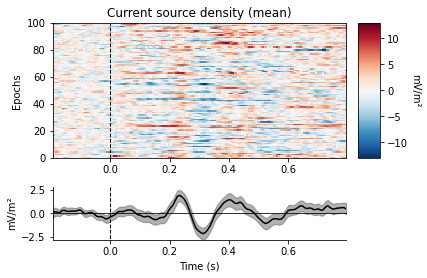

Not setting metadata
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


<ipython-input-44-76e37879f247>:4: RuntimeWarning: Only one channel in group "csd"; cannot combine by method "mean".
  epochs['NonTarget'].plot_image(combine='mean')
<ipython-input-44-76e37879f247>:4: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs['NonTarget'].plot_image(combine='mean')


<Figure size 432x288 with 0 Axes>

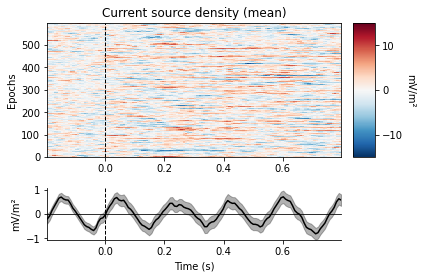

<Figure size 432x288 with 0 Axes>

In [44]:
if display_all_erp_plots:
    epochs['Target'].plot_image(combine='mean')
    plt.gcf().canvas.set_window_title('Target')
    epochs['NonTarget'].plot_image(combine='mean')
    plt.gcf().canvas.set_window_title('Non-Target')

### Same plot but channel wise

In [39]:
dict_electrodes = dict(eeg='EEG') if not apply_CSD else dict(csd='CSD')

if display_all_erp_plots:
    for ch_type, title in dict_electrodes.items():
        layout = mne.channels.find_layout(epochs.info, ch_type=ch_type)
        epochs['Target'].plot_topo_image(layout=layout, fig_facecolor='w',
                                                font_color='k', title=title+' Target Trial x time amplitude')
        epochs['NonTarget'].plot_topo_image(layout=layout, fig_facecolor='w',
                                                font_color='k', title=title+' Non-Target Trial x time amplitude')


# Assess ERP classificaiton accuracy

resample the signal, we don't need that much

In [40]:
new_fs = resample_LDA #
epochs_resampled = epochs.copy().resample(new_fs)
print('resampling to {}Hz'.format(new_fs))

resampling to 32Hz


modify the data matrix to be properly assessed via LDA

In [41]:
X = epochs_resampled._data[:,1,:]  # input data at CZ (TODO:flatten all electrodes)
X = epochs_resampled._data[:,:,:]  # input data at CZ (TODO:flatten all electrodes)
y = epochs_resampled.events[:,2]  # ground truth

# remove the information 
    
#mne.stats.permutation_t_test()
print('Data shape from MNE {}'.format(X.shape))
X = np.moveaxis(X,1,-1)
print('new data shape with sampling prioritized over channels {}'.format(X.shape))
X = X.reshape([X.shape[0],X.shape[1]*X.shape[2]],order='C')
print('Shape for K-fold LDA {}'.format(X.shape))


IndexError: index 1 is out of bounds for axis 1 with size 1

### Compute k-fold LDA

In [42]:
clf = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
kf = KFold(n_splits=nb_k_splits)
kf.get_n_splits(X)

accuracy = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    kscore = clf.score(X_test,y_test)
    print('fold score: {}'.format(np.round(kscore, decimals=3)))
    accuracy.append(kscore)
print('Average accuracy {}-Fold = {}'.format(kf.get_n_splits(X), np.round(np.mean(accuracy), decimals=2)))
clf.fit(X, y)
print('Score with overfitting {}'.format(np.round(clf.score(X,y), decimals=2)))

fold score: 0.95
fold score: 0.936
fold score: 0.907
fold score: 0.914
fold score: 0.914
Average accuracy 5-Fold = 0.92
Score with overfitting 0.97


## Signed R-Square plot 

### Use the function from Wyrm

In [34]:
# From https://github.com/bbci/wyrm/blob/master/wyrm/processing.py
# Bastian Venthur for wyrm
# Code initially from Benjamin Blankertz for bbci (Matlab)

def calculate_signed_r_square_mne(epochs, classes=[0,1], classaxis=0, **kwargs):
    """Calculate the signed r**2 values.
    This method calculates the signed r**2 values over the epochs of the
    ``dat``.
    Parameters
    ----------
    epochs : MNE epoched data
    classes: list, optional 
        (either int index or str for the class name of the epoch))
    classaxis : int, optional
        the dimension containing epochs
    Returns
    -------
    signed_r_square : ndarray
        the signed r**2 values, signed_r_square has one axis less than
        the ``dat`` parameter, the ``classaxis`` has been removed
    Examples
    --------
    >>> dat.data.shape
    (400, 100, 64)
    >>> r = calculate_signed_r_square(dat)
    >>> r.shape
    (100, 64)
    """
    # TODO: explain the algorithm in the docstring and add a reference
    # to a paper.
    # select class 0 and 1
    # TODO: make class 0, 1 variables
    fv1 = epochs[classes[0]]._data
    fv2 = epochs[classes[1]]._data
    # number of epochs per class
    l1 = epochs[classes[0]]._data.shape[classaxis]
    l2 = epochs[classes[1]]._data.shape[classaxis]
    # calculate r-value (Benjamin approved!)
    a = (fv1.mean(axis=classaxis) - fv2.mean(axis=classaxis)) * np.sqrt(l1 * l2)
    b = epochs._data.std(axis=classaxis) * (l1 + l2)
    r = a / b
    # return signed r**2
    return np.sign(r) * np.square(r)

rsq = calculate_signed_r_square_mne(epochs, classes=['Target','NonTarget'])

### make a pandas database to properly display electrodes and samples

In [35]:
# make a pandas database to properly display electrodes and samples
fs = epochs.info['sfreq']
x = np.float64(list(range(rsq.shape[1])))*(1000/fs)
x = x.round(decimals=0).astype(np.int64) + np.int64(pre_epoch*1000)
df_rsq = pd.DataFrame(rsq, columns=x, index=epochs.info['ch_names'])

### Plot rsq

note that using a larger sampling rate will smooth this figure

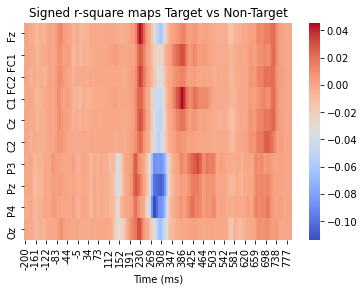

In [36]:
plt.plot()
hm = sns.heatmap(df_rsq,linewidths=0,cmap="coolwarm").set(title='Signed r-square maps Target vs Non-Target', xlabel='Time (ms)')


### Quickly Display a channel

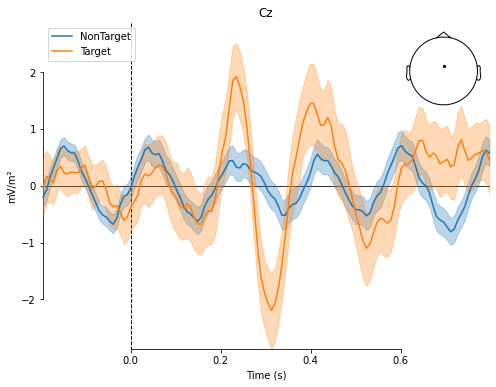

[<Figure size 576x432 with 2 Axes>]

In [67]:
picks = 'Cz'  # <- specify the channel here
#picks = [f'eeg{n}' for n in range(10, 15)]
evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, picks=picks)  # use combine='mean' if several electrode chosen in picks